In [116]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as mp


In [117]:
class neuralNetwork:
    #init nn
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        #кол-во узлов в входном слое
        self.inodes = inputnodes
        #кол-во узлов в скрытом слое
        self.hnodes = hiddennodes
        #кол-во узлов в выходном слое
        self.onodes = outputnodes
        
        #весовые коэф-ты от входного слоя к скрытому
        self.wih = (np.random.rand(self.hnodes, self.inodes) - 0.5)
        #весовые коэф-ты от скрытого слоя к выходному
        self.who = (np.random.rand(self.onodes, self.hnodes) - 0.5)

        #коэф. обучения сети
        self.lr = learningrate
        # запись сигмоиды в качестве анонимной функции
        self.activation_func = lambda x: sc.special.expit(x)
        pass

    # train nn
    def train(self, inputs_list, target_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(target_list, ndmin=2).T

        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_func(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_func(final_inputs)

        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.who.T, output_errors)
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1 - hidden_outputs)), np.transpose(inputs))
        pass

    #query nn
    def query(self, inputs_list):
        #представление массива (одномерной матрицы) входных сигналов в вектор (т.е. транспонирование матрицы 1х3 на 3х1)
        inputs = np.array(inputs_list, ndmin = 2).T
        #вычисление сигналов, приходящих на скрытый слой до применение сигмоиды
        hidden_inputs = np.dot(self.wih, inputs)
        #применение сигмоиды
        hidden_outputs = self.activation_func(hidden_inputs)
        #вычисление сигналов, приходящих на выходной слой до применение сигмоиды
        final_inputs = np.dot(self.who, hidden_outputs)
        #применение сигмоиды
        final_outputs = self.activation_func(final_inputs)
        return final_outputs

In [118]:
input_nodes = 784;
hidden_nodes = 100;
output_nodes = 10;
effectivity = []
for lr in np.arange(0.1, 1, 0.1):
    learning_rate = lr
    n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
    #открытие файла. "r" - открыть только для чтения
    #в data_file записывается указатель файл. следующие обращения к файлу будут через данный указатель 
    data_file = open("dataset/mnist_train.csv", "r")
    #чтение всех строк в файле
    data_list = data_file.readlines()
    #закрытие файла во избежание конкурентности (одновременное использование одного файла несколькими командами)
    data_file.close()
    epochs = 1
    for e in range(epochs):
        for record in data_list:
            all_values = record.split(',')
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
            targets = np.zeros(output_nodes) + 0.01
            targets[int(all_values[0])] = 0.99
            n.train(inputs, targets)
            pass
        pass
    test_dataset_file = open("dataset/mnist_test.csv", "r")
    test_dataset_list = test_dataset_file.readlines()
    test_dataset_file.close()
    scorecard = []

    for record in test_dataset_list:
        all_values = record.split(',')
        correct_value = int(all_values[0])
        inputs = (np.asfarray(all_values[1:])/255.0 * 0.99) + 0.01
        outputs = n.query(inputs)
        label = np.argmax(outputs)
        if(label == correct_value):
            scorecard.append(1)
            pass
        else:
            scorecard.append(0)
            pass
        pass
    scorecard_array = np.asarray(scorecard)
    effectivity.append([lr, sum(scorecard)/len(scorecard)])
print(effectivity)

[[0.1, 0.9518], [0.2, 0.9519], [0.30000000000000004, 0.9461], [0.4, 0.9279], [0.5, 0.9279], [0.6, 0.9112], [0.7000000000000001, 0.9141], [0.8, 0.8735], [0.9, 0.8777]]


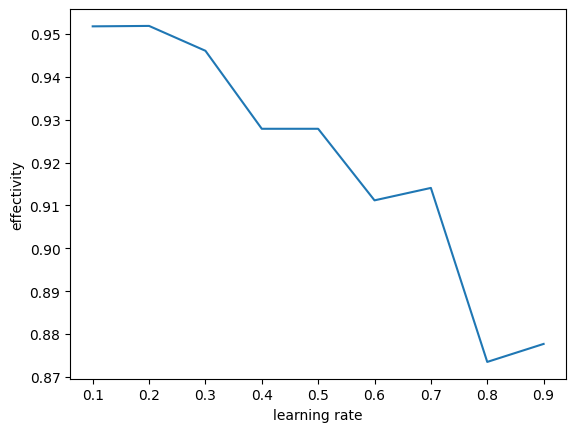

In [127]:
data_for_graphic = [[],[]];
for val in effectivity:
    data_for_graphic[0].append(val[0])
    data_for_graphic[1].append(val[1])
mp.figure()
mp.plot(data_for_graphic[0], data_for_graphic[1])
mp.xlabel("learning rate")
mp.ylabel("effectivity")
mp.show()